In [29]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shap
shap.initjs() 

In [30]:
tf.random.set_seed(8)

### `generate_dataset`

#### Parameters:
- `n_samples`: Number of data points.
- `n_true_predictors`: Number of effective features.
- `n_non_effective_predictors`: Number of noise features.

#### Steps:

1. **Generate Predictors**:  
   **True Predictors**: `n_true_predictors` arrays of random values.  
   **Non-effective Predictors**: `n_non_effective_predictors` arrays of random values.

2. **Define Coefficients and Intercept**:  
   `beta_0`: Intercept (3.0).  
   `true_coefficients`: Random values (2 to 10) for true predictors.

3. **Generate Error Term**:  
   Random noise from a standard normal distribution.

4. **Generate Outcome Variable (`y`)**:  
   Calculated as the sum of the intercept, true predictors multiplied by their coefficients, and the error term.

5. **Combine Predictors into a DataFrame**:  
   Creates a DataFrame with predictors and the outcome variable `y`.

6. **Return**:  
   The DataFrame and true coefficients.

In [31]:
def generate_dataset(n_samples, n_true_predictors, n_non_effective_predictors):
    np.random.seed(8)
    
    # Generate true predictors
    true_predictors = [np.random.rand(n_samples, 1) for _ in range(n_true_predictors)]
    
    # Generate non-effective predictors
    non_effective_predictors = [np.random.rand(n_samples, 1) for _ in range(n_non_effective_predictors)]
    
    # Define the true coefficients and intercept
    beta_0 = 3.0
    true_coefficients = np.random.uniform(2, 10, size=n_true_predictors)
    
    # Generate the error term
    error = np.random.randn(n_samples, 1)
    
    # Generate the outcome variable
    y = beta_0 + sum(beta * x for beta, x in zip(true_coefficients, true_predictors)) + error
    
    # Combine all predictors into a single DataFrame
    predictors = np.hstack(true_predictors + non_effective_predictors)
    columns = [f'x{i+1}' for i in range(n_true_predictors + n_non_effective_predictors)]
    data = pd.DataFrame(predictors, columns=columns)
    data['y'] = y
    
    return data, true_coefficients

In [32]:
# Generate the dataset
n_samples = 1000
n_true_predictors = 5
n_non_effective_predictors = 10
data, true_coefficients = generate_dataset(n_samples, n_true_predictors, n_non_effective_predictors)

true_coefficients

array([2.83254746, 3.08447364, 4.34119098, 3.2972036 , 9.50128631])

In [33]:
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,y
0,0.873429,0.310902,0.901550,0.427570,0.644761,0.927682,0.874056,0.864666,0.551791,0.286776,0.523609,0.306303,0.396934,0.775304,0.819978,17.203240
1,0.968541,0.841306,0.510928,0.201062,0.052693,0.114822,0.749553,0.548416,0.771135,0.192682,0.943392,0.682031,0.814918,0.666387,0.971178,13.190649
2,0.869195,0.390119,0.622906,0.028553,0.827774,0.170850,0.040186,0.674345,0.037946,0.281376,0.436470,0.985193,0.253046,0.851353,0.551960,17.252597
3,0.530856,0.895533,0.208874,0.460936,0.250281,0.740611,0.512623,0.947328,0.373571,0.178981,0.762821,0.916194,0.954600,0.560111,0.965510,11.065163
4,0.232728,0.098472,0.547106,0.147156,0.500830,0.135312,0.458617,0.542167,0.655390,0.873041,0.935329,0.743461,0.279753,0.490464,0.560004,10.360125


In [34]:
X = data.drop(columns='y')
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

## Basic NN at first

In [35]:
# # Define a custom callback to record weights
# class WeightsHistory(Callback):
#     def __init__(self):
#         self.first_layer_weights = []
#         self.last_layer_weights = []
        
#     def on_epoch_end(self, epoch, logs=None):
#         self.first_layer_weights.append(self.model.layers[1].get_weights()[0].copy())
#         self.last_layer_weights.append(self.model.layers[-1].get_weights()[0].copy())

In [36]:
# Define the model
model = Sequential()

model.add(Input(shape=(X_train.shape[1],)))

# hidden layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))


# output layer
model.add(Dense(1))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1)

# Compile the model
model.compile(optimizer='adam', loss='mse')



model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Instantiate the custom callback
#weights_history = WeightsHistory()
start_time = time.time()
# Train the model with the custom callback
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0, callbacks=[early_stopping])


In [38]:
y_pred = model.predict(X_test)
end_time = time.time()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [39]:
estimation_time = end_time - start_time
print(estimation_time)

4.695003032684326


In [40]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")


Root Mean Squared Error: 1.0027271725290818


In [41]:
r2 = r2_score(y_test, y_pred)
print(f"R^2 score: {r2}")

R^2 score: 0.9157547419726093


In [42]:
y_pred = y_pred.flatten()

In [43]:
# Create a DataFrame for the results
results = pd.DataFrame({'True Values': y_test, 'Predicted Values': y_pred}).reset_index(drop=True)
results

,True Values,Predicted Values
0,10.784186,10.570272
1,9.790402,9.711564
2,8.669460,7.959044
3,12.198899,12.170347
4,13.283112,14.085130
...,...,...
195,14.792494,16.357462
196,14.405954,13.894126
197,15.349697,14.259566
198,20.609995,21.272449


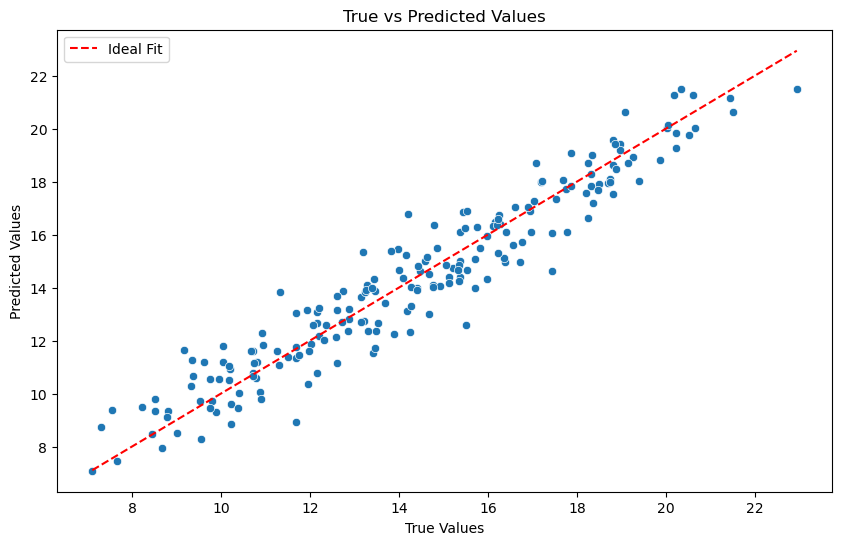

In [44]:
# Plot the true vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='True Values', y='Predicted Values', data=results)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

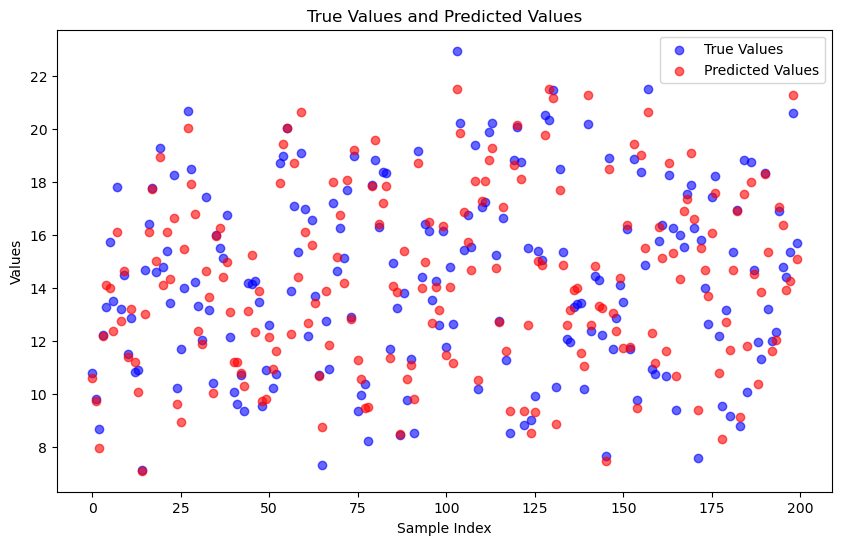

In [45]:
# Plot the true vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', alpha=0.6, label='True Values')
plt.scatter(range(len(y_pred)), y_pred, color='red', alpha=0.6, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('True Values and Predicted Values')
plt.legend()
plt.show()

In [46]:
start_time = time.time()
# Create a masker from the input data
masker = shap.maskers.Independent(X_train)

# Create the explainer with the model and masker
explainer = shap.Explainer(model, masker)

# Get SHAP values for the input data
shap_values = explainer(X_test)

# Verify the type of shap_values
print("Type of shap_values:", type(shap_values))


PermutationExplainer explainer: 201it [00:22,  4.94it/s]                         

Type of shap_values: <class 'shap._explanation.Explanation'>


In [47]:
# Check the dimensions
print("Number of features:", len(X.columns))
print("Shape of shap_values:", shap_values.shape)

Number of features: 15
Shape of shap_values: (200, 15)


### How to understand how it makes an individual prediction

This is for the first prediction where f(x) is the predition. All the SHAP values show how much each feature effected that specific prediction

In [48]:

# # Waterfall plot for the first observation
# shap.plots.waterfall(shap_values[0])

In [49]:
# shap.plots.force(shap_values[0])

## SHAP Summary Bar Plot

- For each feature, calculate the mean SHAP value across all observations. 
- Take the mean of the absolute values as we do not want positive and negative values to offset each other
- There is one bar for each feature

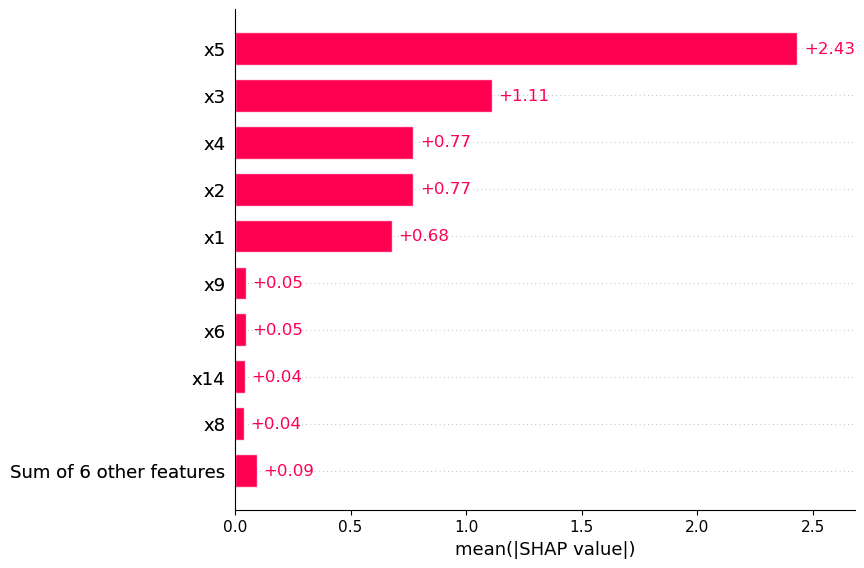

In [50]:
shap.plots.bar(shap_values)

# SHAP VALUES SEEM TO BE CHANGIN EVERYTIME
## WHY IS THIS

## SHAP Beeswarm Plot Explanation

- Visualizes all of the SHAP values. 
- On the y-axis, the values are grouped by feature. For each group, the color of the points is determined by the feature value (i.e., higher feature values are redder).


In [51]:
# # Beeswarm plot
# shap.plots.beeswarm(shap_values)

In [52]:
# Extract the actual SHAP values from the Explanation object
shap_values_array = shap_values.values if isinstance(shap_values, shap.Explanation) else shap_values
type(shap_values_array)
# Extract the mean absolute SHAP values
mean_shap_values = np.abs(shap_values_array).mean(axis=0)
feature_names = X.columns

# Create a dataframe with the extracted values
shap_df = pd.DataFrame({
    "Feature": feature_names,
    "Mean_SHAP_Value": mean_shap_values
})

shap_df = shap_df.sort_values(by="Mean_SHAP_Value", ascending=False).reset_index(drop=True)
shap_top_5 = shap_df.head(10)

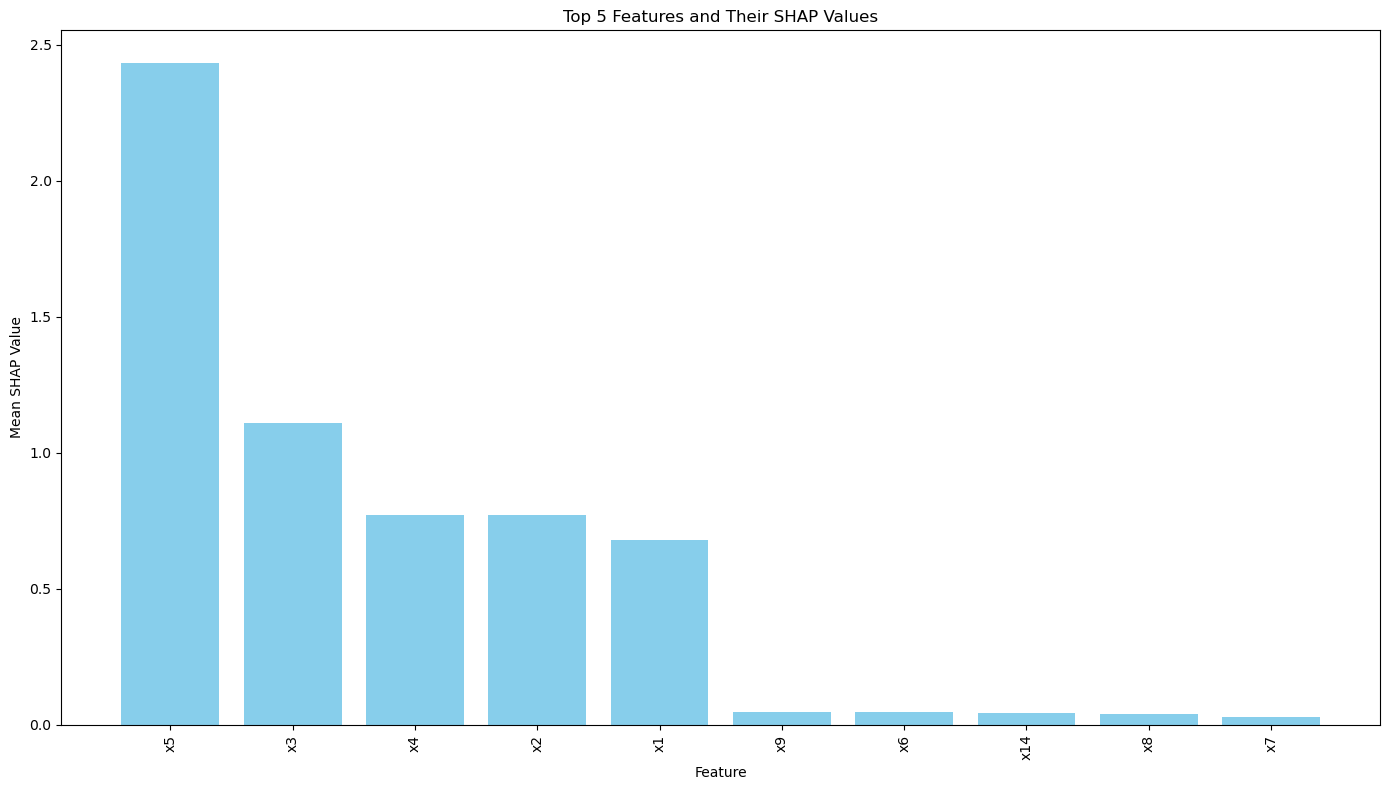

In [53]:
plt.figure(figsize=(14, 8))

plt.bar(shap_top_5['Feature'], shap_top_5['Mean_SHAP_Value'], color='skyblue')

plt.xlabel('Feature')
plt.ylabel('Mean SHAP Value')
plt.title('Top 5 Features and Their SHAP Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

end_time = time.time()

In [54]:
explainability_time = end_time - start_time

In [57]:
nn_metrics = []
# LassoCV model metrics
#fpr, fnr = calculate_fp_fn_rates(cf_matrix)
nn_metrics.append({
    'simulation_size': '5-10-1_000',
    'model': 'NN',
    'Inference Time (sec)': round(estimation_time, 3),
    'R Squared': r2,
    'RMSE': rmse,
    'Explanation/Interpretation Task': 'Explain Neural Network',
    'Interpretation Time (sec)': round(explainability_time, 3),
    #'top_5_features': top_5_features_str
    # 'auc': round(roc_auc, 3),
    # 'false_positive_rate': round(fpr, 3),
    # 'false_negative_rate': round(fnr, 3)
})

nn_metrics_df = pd.DataFrame(nn_metrics)
nn_metrics_df

,simulation_size,model,Inference Time (sec),R Squared,RMSE,Explanation/Interpretation Task,Interpretation Time (sec)
0,5-10-1_000,NN,4.695,0.915755,1.002727,Explain Neural Network,22.639


In [58]:
nn_metrics_df.to_csv('5-10-1_000-metrics.csv', mode='a', index=False, header=False)